In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [ ]:
#使用混合精度(Mixed precision)能減少記憶體使用量與訓練時間，避免出現記憶體不足的錯誤，未來在本系列TensorFlow2基礎篇會介紹
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

In [ ]:
import os
import numpy as np
import random
os.environ['TF_DETERMINISTIC_OPS'] ='1'
os.environ['TF_CUDNN_DETERMINISTIC']='1'
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)
SEED=1
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 1. 資料準備

In [ ]:
from tensorflow.keras.datasets import cifar10

In [ ]:
(x_img_train,y_label_train),\
(x_img_test,y_label_test)=cifar10.load_data() 

170508288/170498071 [==============================] - 11s 0us/step


In [ ]:
y_label_train=y_label_train.reshape(-1)
y_label_test=y_label_test.reshape(-1)

In [ ]:
print("train data:",'images:',x_img_train.shape,"labels:",y_label_train.shape) 
print("test  data:",'images:',x_img_test.shape ," labels:",y_label_test.shape) 

train data: images: (50000, 32, 32, 3) labels: (50000,)
test  data: images: (10000, 32, 32, 3)  labels: (10000,)


In [ ]:
x_img_train_normalize = x_img_train.astype('float32') / 255.0
x_img_test_normalize = x_img_test.astype('float32') / 255.0

In [ ]:
from tensorflow.keras import utils
y_train_onehot = utils.to_categorical(y_label_train)
y_test_onehot = utils.to_categorical(y_label_test)

In [ ]:
from sklearn.model_selection import train_test_split
x_img_train_normalize,x_img_val_normalize,y_train_onehot,y_val_onehot=\
      train_test_split(x_img_train_normalize,y_train_onehot, 
              test_size=0.2, random_state=888)

In [ ]:
print("train data:",'images:',x_img_train_normalize.shape,
      " labels:",y_train_onehot.shape) 
print("val data:",'images:',x_img_val_normalize.shape,
      " labels:",y_val_onehot.shape) 
print("test  data:",'images:',x_img_test_normalize.shape ,
      " labels:",y_test_onehot.shape) 

train data: images: (40000, 32, 32, 3)  labels: (40000, 10)
val data: images: (10000, 32, 32, 3)  labels: (10000, 10)
test  data: images: (10000, 32, 32, 3)  labels: (10000, 10)


# 建立模型

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D,Dropout, MaxPooling2D,Dense,Activation,BatchNormalization, Flatten

In [ ]:
def block(p_bname,p_filters,p_conv,p_drop_rate,p_is_bn):
  for i in range(p_conv):
    model.add(Conv2D(filters=p_filters,kernel_size=(3,3),
             activation='relu',padding='same',
             name=p_bname+'_conv'+str(i)))
    if p_is_bn:model.add(BatchNormalization(name=p_bname+'_Bn'+str(i)))
  model.add(MaxPooling2D(pool_size=(2, 2),name=p_bname+'_pool'))
  if p_is_bn:model.add(BatchNormalization(name=p_bname+'_Bn_pool'))
  if p_drop_rate>0: model.add(Dropout(drop_rate,name=p_bname+'_Dr'))  

In [ ]:
drop_rate=0.5
model = Sequential()
model.add(Input(shape=(32, 32,3)))
block(p_bname='B1',p_filters=32,p_conv=3,
   p_drop_rate=drop_rate,p_is_bn=True)
block(p_bname='B2',p_filters=64,p_conv=3,
   p_drop_rate=drop_rate,p_is_bn=True)
block(p_bname='B3',p_filters=128,p_conv=3,
   p_drop_rate=drop_rate,p_is_bn=True)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 B1_conv0 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 B1_Bn0 (BatchNormalization)  (None, 32, 32, 32)       128       
                                                                 
 B1_conv1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 B1_Bn1 (BatchNormalization)  (None, 32, 32, 32)       128       
                                                                 
 B1_conv2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 B1_Bn2 (BatchNormalization)  (None, 32, 32, 32)       128       
                                                                 
 B1_pool (MaxPooling2D)      (None, 16, 16, 32)        0

# 訓練模型

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=15)

In [ ]:
!mkdir Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="Model/Cifar_C345P1_DrBnErAu.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
BATCH_SIZE=200

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,horizontal_flip=True,
    width_shift_range=0.2,height_shift_range=0.2,
    zoom_range=0.2  )

In [ ]:
BATCH_SIZE=200

In [ ]:
train_history=model.fit(
  datagen.flow(x=x_img_train_normalize,
         y=y_train_onehot,
         batch_size=BATCH_SIZE),
  steps_per_epoch = len(x_img_train_normalize) / BATCH_SIZE, 
  validation_data=(x_img_val_normalize, y_val_onehot),
  epochs=200,callbacks=[early_stopping,checkpoint]) 

Epoch 1/200
200/200 [==============================] - ETA: 0s - loss: 1.8844 - acc: 0.3257
Epoch 1: val_acc improved from -inf to 0.10520, saving model to Model/Cifar_C345P1_DrBnErAu.h5
200/200 [==============================] - 43s 151ms/step - loss: 1.8844 - acc: 0.3257 - val_loss: 4.4816 - val_acc: 0.1052
Epoch 2/200
200/200 [==============================] - ETA: 0s - loss: 1.5662 - acc: 0.4268
Epoch 2: val_acc improved from 0.10520 to 0.19190, saving model to Model/Cifar_C345P1_DrBnErAu.h5
200/200 [==============================] - 29s 146ms/step - loss: 1.5662 - acc: 0.4268 - val_loss: 3.1977 - val_acc: 0.1919
Epoch 3/200
200/200 [==============================] - ETA: 0s - loss: 1.4439 - acc: 0.4752
Epoch 3: val_acc improved from 0.19190 to 0.40690, saving model to Model/Cifar_C345P1_DrBnErAu.h5
200/200 [==============================] - 31s 156ms/step - loss: 1.4439 - acc: 0.4752 - val_loss: 1.8539 - val_acc: 0.4069
Epoch 4/200
200/200 [==============================] - ETA: 0

In [ ]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train_key,valid_key):
    plt.plot(train_history.history[train_key],'--')
    plt.plot(train_history.history[valid_key])
    plt.title('Train History')
    plt.ylabel(train_key)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

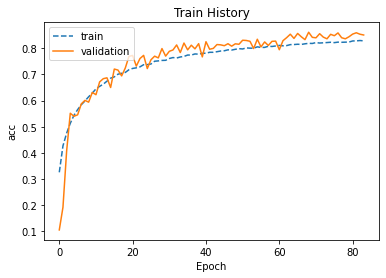

In [ ]:
show_train_history(train_history,'acc','val_acc')

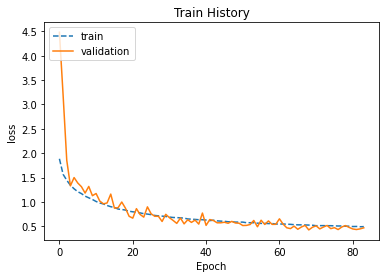

In [ ]:
show_train_history(train_history,'loss','val_loss')

# 評估模型準確率

In [ ]:
scores = model.evaluate(x_img_test_normalize,y_test_onehot)

313/313 [==============================] - 2s 5ms/step - loss: 0.5023 - acc: 0.8406


In [ ]:
print('test_loss=',scores[0],'test_acc=',scores[1])

test_loss= 0.5023000240325928 test_acc= 0.8406000137329102


# 載入最佳模型

In [ ]:
model.load_weights(filepath)

In [ ]:
scores = model.evaluate(x_img_test_normalize,y_test_onehot)
scores[1]

313/313 [==============================] - 2s 5ms/step - loss: 0.4454 - acc: 0.8573


0.8572999835014343

In [ ]:
print('test_loss=',scores[0],'test_acc=',scores[1])

test_loss= 0.4454142451286316 test_acc= 0.8572999835014343


# 進行預測

In [ ]:
probability=model.predict(x_img_test_normalize)

In [ ]:
prediction=tf.argmax(probability, axis=-1).numpy()

In [ ]:
prediction[:10]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])

# 查看預測結果

In [ ]:
import matplotlib.pyplot as plt 

In [ ]:
label_dict={0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
      5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

In [ ]:
def plot_images_labels_prediction(
    images,labels,prediction,idx,num=10):
    fig = plt.gcf().set_size_inches(12, 12)    
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx], cmap='binary')
        title= str(idx)+',' +label_dict[labels[idx]]
        if len(prediction)>0:
            title+="=>"+label_dict[prediction[idx]]
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

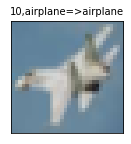

In [ ]:
plot_images_labels_prediction(x_img_test,y_label_test,prediction,idx=10,num=1)

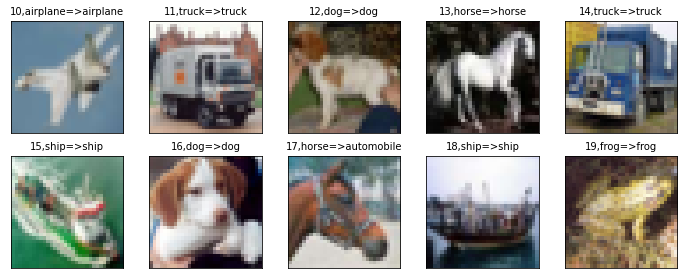

In [ ]:
plot_images_labels_prediction(x_img_test,y_label_test,prediction,idx=10,num=10)

# 查看預測機率

In [ ]:
def show_predicted_probability(
    images,labels,prediction,probability,idx):
  plt.figure(figsize=(1,1));
  plt.xticks([]);plt.yticks([])
  plt.imshow(images[idx],cmap='binary')
  plt.show()
  print('label:',label_dict[labels[idx]],
        'predict:',label_dict[prediction[idx]]) 
  for i in range(10):
    print('%-10s Probability:%.9f'%(label_dict[i],probability[idx][i]))      

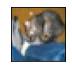

label: cat predict: cat
airplane   Probability:0.000004566
automobile Probability:0.000812288
bird       Probability:0.000377428
cat        Probability:0.936725557
deer       Probability:0.000163102
dog        Probability:0.060272638
frog       Probability:0.001305880
horse      Probability:0.000011246
ship       Probability:0.000309438
truck      Probability:0.000017894


In [ ]:
show_predicted_probability(x_img_test,y_label_test,prediction,probability,0) 

# confusion matrix

In [ ]:
import pandas as pd

In [ ]:
pd.crosstab(y_label_test,prediction,rownames=['label'],colnames=['predict'])

predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,815,23,15,6,11,0,4,5,68,53
1,4,949,0,1,0,0,0,0,4,42
2,36,1,795,14,33,43,50,7,12,9
3,10,6,22,670,40,134,60,9,25,24
4,4,2,26,19,832,13,75,18,7,4
5,3,4,12,65,30,830,20,20,3,13
6,3,4,4,9,5,4,958,3,6,4
7,4,3,7,13,46,33,16,853,5,20
8,16,14,0,2,0,0,5,0,943,20


In [ ]:
df = pd.DataFrame({'label':y_label_test, 'predict':prediction})

In [ ]:
df[:5]

,label,predict
0,3,3
1,8,8
2,8,8
3,0,0
4,6,6


In [ ]:
df[(df.label==5)&(df.predict==3)]

,label,predict
321,5,3
551,5,3
598,5,3
639,5,3
749,5,3
...,...,...
9300,5,3
9369,5,3
9414,5,3
9616,5,3


# 查看預測錯誤資料

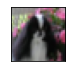

label: dog predict: dog
airplane   Probability:0.002530106
automobile Probability:0.001071936
bird       Probability:0.019298716
cat        Probability:0.206852362
deer       Probability:0.008633681
dog        Probability:0.713366091
frog       Probability:0.000146370
horse      Probability:0.042067774
ship       Probability:0.000447667
truck      Probability:0.005585275


In [ ]:
show_predicted_probability(x_img_test,y_label_test,prediction,probability,42)

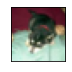

label: dog predict: dog
airplane   Probability:0.000586030
automobile Probability:0.000132141
bird       Probability:0.000524354
cat        Probability:0.158157974
deer       Probability:0.001188276
dog        Probability:0.824771643
frog       Probability:0.012757998
horse      Probability:0.000982770
ship       Probability:0.000013329
truck      Probability:0.000885427


In [ ]:
show_predicted_probability(x_img_test,y_label_test,prediction,probability,128)